In [23]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

In [2]:
df_fraud = pd.read_csv('fraude_tc.csv')

In [3]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


Observo que todos los datos son numéricos y no tengo faltantes. Eso facilita mucho las cosas.

In [4]:
df_fraud.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


De las 8 columnas que tiene el dataset, veo que 5 de ellas son binarias, incluyendo la columna de la clase. También observo que la columna 'Fraud', la clase, está muy imbalanceada. Hasta el percentil 75 contiene valores en 0, aparentemente.<br>
También identifico que las columnas no binarias tienen varianzas muy grandes.

([<matplotlib.patches.Wedge at 0x1ccf9473490>,
 [Text(-1.058791700494653, 0.29826185636725505, 'Fraud'),
  Text(1.058791700494653, -0.2982618563672552, 'Not Fraud')],
 [Text(-0.5775227457243561, 0.16268828529123003, '91.3%'),
  Text(0.5775227457243561, -0.16268828529123008, '8.7%')])

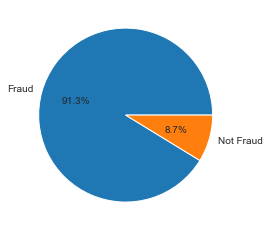

In [9]:
sns.set_style('whitegrid')
plt.pie(df_fraud['fraud'].value_counts(), labels=['Fraud', 'Not Fraud'], autopct='%1.1f%%')

Con este gráfico confirmo la gran diferencia entre los valores fraudulentos y los no fraudulentos. Habrá que utilizar alguna técnica para equilibrar los datos.

In [49]:
#Elimino outliers de todas las columnas, menos la columna de fraud
no_outliers = df_fraud[(np.abs(stats.zscore(df_fraud.iloc[:,:-1])) < 3).all(axis=1)]
outliers = df_fraud[~(np.abs(stats.zscore(df_fraud.iloc[:,:-1])) < 3).all(axis=1)]

([<matplotlib.patches.Wedge at 0x1cd3b9bcb50>,
 [Text(-1.0733272386566193, 0.24076677253673717, ''),
  Text(1.073327233021066, -0.24076679765977416, '')],
 [Text(-0.5854512210854286, 0.1313273304745839, '93.0%'),
  Text(0.5854512180114905, -0.1313273441780586, '7.0%')])

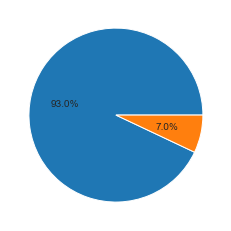

In [50]:
plt.pie(no_outliers['fraud'].value_counts(), autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x1cd3ba03df0>,
 [Text(-0.11514200673576823, 1.0939571830217398, ''),
  Text(0.11514190431210423, -1.0939571938021078, '')],
 [Text(-0.06280473094678266, 0.5967039180118581, '53.3%'),
  Text(0.06280467507932957, -0.5967039238920587, '46.7%')])

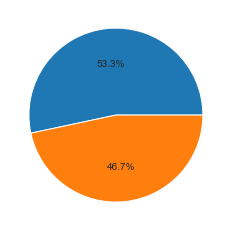

In [51]:
plt.pie(outliers['fraud'].value_counts(), autopct='%1.1f%%')

Al eliminar outliers del dataset veo que la proporción de fraudes se mantiene muy similar. Entre los outliers, los datos se encuentran más balanceados. Me parece que no es necesario eliminar ningún dato.

# Selección del modelo

In [87]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [55]:
x = df_fraud.drop(['fraud'], axis=1)
y = df_fraud['fraud']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [59]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight='balanced')
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

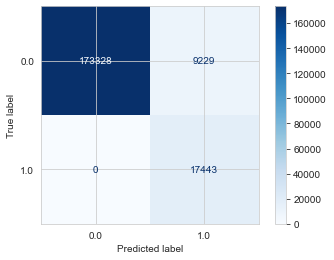

In [90]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    182557
         1.0       0.65      1.00      0.79     17443

    accuracy                           0.95    200000
   macro avg       0.83      0.97      0.88    200000
weighted avg       0.97      0.95      0.96    200000



In [76]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.953855
AUC: 0.9747229632388787


In [102]:
xgb = XGBClassifier(n_estimators=100, max_depth=2, random_state=0, use_label_encoder=False)
xgb.fit(x_train, y_train)
y_pred_2 = xgb.predict(x_test)

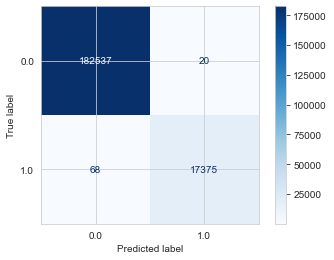

In [105]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, cmap='Blues')

In [106]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182557
         1.0       1.00      1.00      1.00     17443

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [107]:
print('Accuracy:', accuracy_score(y_test, y_pred_2))
print('AUC:', roc_auc_score(y_test, y_pred_2))

Accuracy: 0.99956
AUC: 0.9979960166028047
